<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [49]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [50]:
DATA_DIR = '/kaggle/input/faces-dataset-small' #/content/data/'
image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


In [51]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [52]:
def get_dataloader(image_size=image_size, batch_size=batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
    ]))

  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl

In [53]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [54]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [55]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [56]:
#TODO: build dataloader and transfer it to device
# Зададим девайс: cuda или cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [57]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [58]:
train_dl = get_dataloader()
train_dl = DeviceDataLoader(train_dl, device)


In [59]:
#batch = next(iter(train_dl))

In [60]:
#show_images(batch[0][2])

In [61]:
#show_images(denorm(batch[0][2]))

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [62]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=2, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1, kernel_size=8, stride=1, padding=0, bias=False),   # out: 512 x 1 x 1
    nn.Flatten(),  # [B, 1, 1, 1] → [B, 1]
    #nn.Sigmoid()
    )

In [63]:
discriminator = to_device(discriminator, device)

In [64]:
latent_size = 128 # choose latent size

In [65]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [66]:
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
latent.shape

torch.Size([64, 128, 1, 1])

In [67]:
#gen_out = generator(latent)
#gen_out.shape

In [68]:
#dis_out = discriminator(gen_out)
#dis_out

In [69]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 3 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [70]:
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [71]:
def fit(model, criterion, epochs, lr, start_idx=1):
  # TODO: build optimizers and train your GAN
   # Losses & scores
   losses_g = []
   losses_d = []
   real_scores = []
   fake_scores = []

  # Create optimizers
   optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr*2, betas=(0.5, 0.999))
   }

   for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

             # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.full((real_images.size(0), 1), 0.85, device=device)

            #real_targets = torch.ones(real_images.size(0), 1, device=device)
            #print((real_preds.shape, real_targets.shape))
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            #show_images(fake_images)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)

            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

             # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))


        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

   return losses_g, losses_d, real_scores, fake_scores




In [72]:
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCEWithLogitsLoss(),
    "generator": nn.BCEWithLogitsLoss()
}
epochs = 40

In [73]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 11.8553, loss_d: 1.0074, real_score: 1.5855, fake_score: -5.3240


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 14.5618, loss_d: 0.8674, real_score: 1.8603, fake_score: -9.5681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 10.4777, loss_d: 0.6904, real_score: 1.8817, fake_score: -6.7909


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 10.4068, loss_d: 0.8856, real_score: 1.8328, fake_score: -7.1137


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 7.3055, loss_d: 0.8962, real_score: 1.7041, fake_score: -4.5241


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.5984, loss_d: 0.9055, real_score: 1.1770, fake_score: -3.1815


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 3.9969, loss_d: 0.9633, real_score: 1.0447, fake_score: -2.2862


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.1198, loss_d: 0.8983, real_score: 1.0936, fake_score: -2.5213


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 3.8725, loss_d: 0.8911, real_score: 1.0666, fake_score: -2.2548


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.2255, loss_d: 0.8942, real_score: 1.1303, fake_score: -2.3796


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.3642, loss_d: 0.9657, real_score: 1.0283, fake_score: -2.1977


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.7675, loss_d: 0.8813, real_score: 1.1523, fake_score: -2.3516


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.3577, loss_d: 0.8711, real_score: 1.1231, fake_score: -2.3845


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.1508, loss_d: 0.9513, real_score: 0.9253, fake_score: -2.1153


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.3066, loss_d: 0.9242, real_score: 1.0144, fake_score: -2.2465


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.2990, loss_d: 0.8976, real_score: 1.0011, fake_score: -2.1628


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.2785, loss_d: 0.9712, real_score: 0.9550, fake_score: -2.2157


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.0202, loss_d: 0.9977, real_score: 0.8970, fake_score: -1.9639


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 3.9223, loss_d: 1.0192, real_score: 0.8326, fake_score: -2.0196


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.0557, loss_d: 0.9122, real_score: 0.9534, fake_score: -2.1699


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 4.5155, loss_d: 0.9667, real_score: 0.9831, fake_score: -2.1950


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.0974, loss_d: 1.0078, real_score: 0.8869, fake_score: -2.1251


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 3.9456, loss_d: 0.9787, real_score: 0.9085, fake_score: -2.0200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.0225, loss_d: 0.9772, real_score: 0.8933, fake_score: -2.1232


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 4.0527, loss_d: 0.9047, real_score: 0.9295, fake_score: -2.0026


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 3.9774, loss_d: 0.9711, real_score: 0.8620, fake_score: -2.2287


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 4.2874, loss_d: 0.9541, real_score: 0.9864, fake_score: -2.1975


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 4.1289, loss_d: 0.9497, real_score: 0.9429, fake_score: -2.2413


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 4.1956, loss_d: 0.8759, real_score: 1.0316, fake_score: -2.1482


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 4.2162, loss_d: 0.8966, real_score: 1.1012, fake_score: -2.4416


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 3.9951, loss_d: 0.8497, real_score: 1.0611, fake_score: -2.2772


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.2016, loss_d: 0.9634, real_score: 1.0120, fake_score: -2.1805


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.0716, loss_d: 0.9008, real_score: 1.0737, fake_score: -2.3192


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 4.3228, loss_d: 0.8354, real_score: 1.1279, fake_score: -2.4604


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 4.3152, loss_d: 0.8372, real_score: 1.1673, fake_score: -2.5574


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 4.4435, loss_d: 0.8461, real_score: 1.1708, fake_score: -2.4284


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.4072, loss_d: 0.8042, real_score: 1.2678, fake_score: -2.5727


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 4.2609, loss_d: 0.7869, real_score: 1.2359, fake_score: -2.5994


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 4.6033, loss_d: 0.8276, real_score: 1.2754, fake_score: -2.6254


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 4.2255, loss_d: 0.7431, real_score: 1.3349, fake_score: -2.6422
Saving generated-images-0040.png


In [74]:
losses_g, losses_d, real_scores, fake_scores = history

In [75]:
generated_img = cv2.imread('/kaggle/working/generated/generated-images-0010.png')
generated_img = generated_img[:, :, [2, 1, 0]]

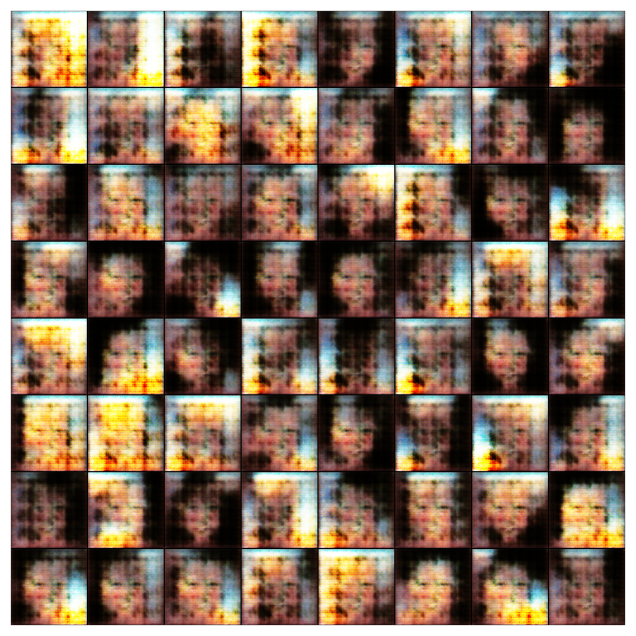

In [76]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

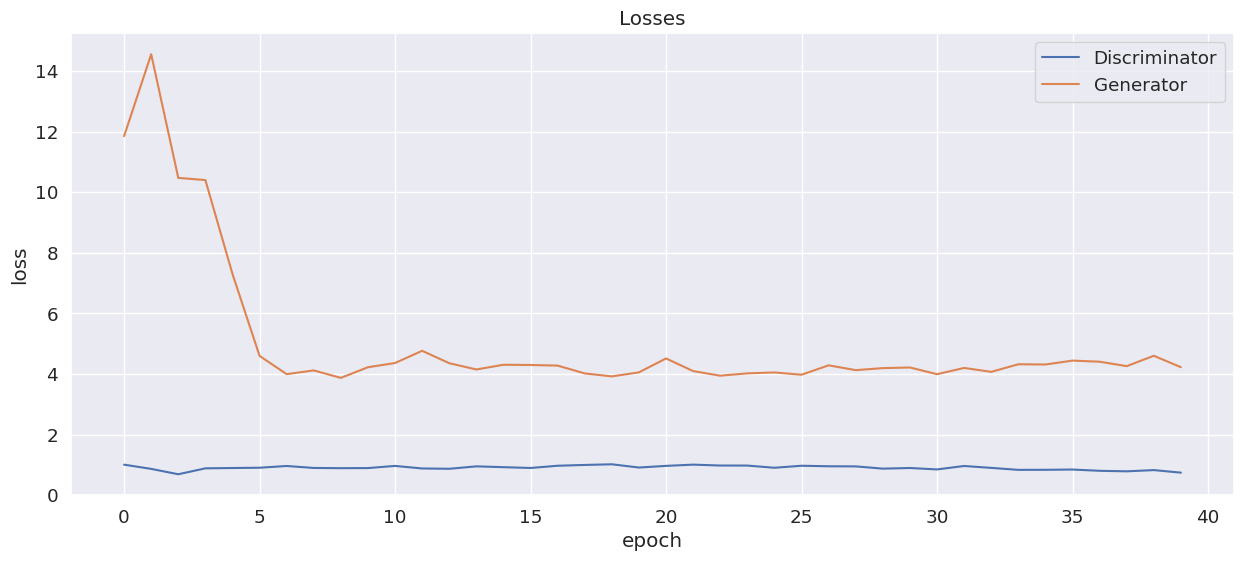

In [77]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [78]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [79]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

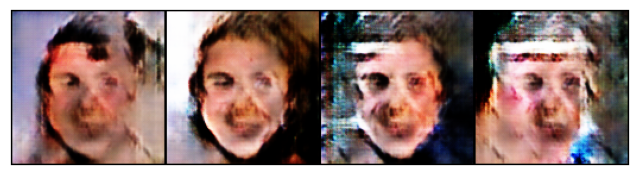

In [80]:
show_images(fake_images.to('cpu'))

Как вам качество получившихся изображений?

Качество  плохое. Попробуем реализовать WGAN

In [81]:
def fit_wgan(generator, discriminator, dataloader, device, epochs=5, latent_dim=100, lr=5e-5, clip_value=0.01, n_critic=5):
    generator.to(device)
    discriminator.to(device)

    optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr*2)
    optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        loss_g_epoch = []
        loss_d_epoch = []
        real_score_epoch = []
        fake_score_epoch = []

        for i, (real_imgs, _) in enumerate(tqdm(dataloader)):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Discriminator
            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_imgs = generator(z).detach()

            # Compute WGAN loss
            real_out = discriminator(real_imgs)
            fake_out = discriminator(fake_imgs)
            loss_D = -torch.mean(real_out) + torch.mean(fake_out)
            loss_D.backward()
            optimizer_D.step()

            # Weight clipping
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            # Save scores
            real_score_epoch.append(real_out.mean().item())
            fake_score_epoch.append(fake_out.mean().item())
            loss_d_epoch.append(loss_D.item())

            # Train the generator every n_critic steps
            if i % n_critic == 0:
                optimizer_G.zero_grad()
                gen_imgs = generator(z)
                loss_G = -torch.mean(discriminator(gen_imgs))
                loss_G.backward()
                optimizer_G.step()
                loss_g_epoch.append(loss_G.item())

        losses_g.append(np.mean(loss_g_epoch))
        losses_d.append(np.mean(loss_d_epoch))
        real_scores.append(np.mean(real_score_epoch))
        fake_scores.append(np.mean(fake_score_epoch))

        print(f"Epoch [{epoch+1}/{epochs}] | Loss_D: {losses_d[-1]:.4f} | Loss_G: {losses_g[-1]:.4f} | Real Score: {real_scores[-1]:.4f} | Fake Score: {fake_scores[-1]:.4f}")

        # Save sample output
        with torch.no_grad():
            sample = generator(torch.randn(64, latent_dim, 1, 1).to(device))
            save_image(sample * 0.5 + 0.5, f"generated_epoch_{epoch+1}.png")  # Rescale to [0, 1]

    print("Training complete.")
    #return losses_g, losses_d, real_scores, fake_scores



In [82]:

epochs = 40
lr = 0.00004
clip_value = 0.01
n_critic = 5

fit_wgan(
    generator=generator,
    discriminator=discriminator,
    dataloader=train_dl,     
    device=device,           
    epochs=epochs,
    latent_dim=latent_size,
    lr=lr,
    clip_value=clip_value,
    n_critic=n_critic
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/40] | Loss_D: -0.0881 | Loss_G: 0.0127 | Real Score: -0.0169 | Fake Score: -0.1050


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/40] | Loss_D: 0.0012 | Loss_G: 0.0113 | Real Score: -0.0124 | Fake Score: -0.0112


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/40] | Loss_D: 0.0006 | Loss_G: 0.0118 | Real Score: -0.0123 | Fake Score: -0.0117


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/40] | Loss_D: 0.0003 | Loss_G: 0.0121 | Real Score: -0.0124 | Fake Score: -0.0121


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/40] | Loss_D: 0.0002 | Loss_G: 0.0125 | Real Score: -0.0126 | Fake Score: -0.0124


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/40] | Loss_D: 0.0001 | Loss_G: 0.0127 | Real Score: -0.0128 | Fake Score: -0.0127


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/40] | Loss_D: 0.0000 | Loss_G: 0.0131 | Real Score: -0.0131 | Fake Score: -0.0130


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/40] | Loss_D: -0.0000 | Loss_G: 0.0133 | Real Score: -0.0133 | Fake Score: -0.0133


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/40] | Loss_D: -0.0001 | Loss_G: 0.0134 | Real Score: -0.0134 | Fake Score: -0.0134


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/40] | Loss_D: -0.0001 | Loss_G: 0.0134 | Real Score: -0.0133 | Fake Score: -0.0134


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/40] | Loss_D: -0.0001 | Loss_G: 0.0135 | Real Score: -0.0133 | Fake Score: -0.0134


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/40] | Loss_D: -0.0002 | Loss_G: 0.0130 | Real Score: -0.0127 | Fake Score: -0.0129


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/40] | Loss_D: -0.0003 | Loss_G: 0.0130 | Real Score: -0.0127 | Fake Score: -0.0130


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/40] | Loss_D: -0.0010 | Loss_G: 0.0123 | Real Score: -0.0109 | Fake Score: -0.0119


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/40] | Loss_D: -0.0034 | Loss_G: 0.0130 | Real Score: -0.0076 | Fake Score: -0.0110


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/40] | Loss_D: -0.0355 | Loss_G: 0.0457 | Real Score: 0.0046 | Fake Score: -0.0309


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/40] | Loss_D: -0.2033 | Loss_G: 0.1290 | Real Score: 0.1173 | Fake Score: -0.0859


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/40] | Loss_D: -0.4078 | Loss_G: 0.2671 | Real Score: 0.2215 | Fake Score: -0.1863


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/40] | Loss_D: -0.5842 | Loss_G: 0.3463 | Real Score: 0.3205 | Fake Score: -0.2638


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/40] | Loss_D: -0.7538 | Loss_G: 0.5122 | Real Score: 0.3631 | Fake Score: -0.3907


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/40] | Loss_D: -0.8671 | Loss_G: 0.6235 | Real Score: 0.3628 | Fake Score: -0.5043


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/40] | Loss_D: -0.9076 | Loss_G: 0.6781 | Real Score: 0.3759 | Fake Score: -0.5317


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/40] | Loss_D: -0.9403 | Loss_G: 0.7978 | Real Score: 0.3797 | Fake Score: -0.5606


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/40] | Loss_D: -1.0424 | Loss_G: 0.7729 | Real Score: 0.4207 | Fake Score: -0.6217


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/40] | Loss_D: -1.1145 | Loss_G: 0.7857 | Real Score: 0.4135 | Fake Score: -0.7010


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/40] | Loss_D: -1.1650 | Loss_G: 0.8668 | Real Score: 0.4484 | Fake Score: -0.7166


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/40] | Loss_D: -1.2348 | Loss_G: 0.8744 | Real Score: 0.4881 | Fake Score: -0.7467


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/40] | Loss_D: -1.2857 | Loss_G: 0.9385 | Real Score: 0.5074 | Fake Score: -0.7783


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/40] | Loss_D: -1.3472 | Loss_G: 0.9547 | Real Score: 0.5370 | Fake Score: -0.8102


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/40] | Loss_D: -1.3566 | Loss_G: 0.9647 | Real Score: 0.5349 | Fake Score: -0.8218


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/40] | Loss_D: -1.3812 | Loss_G: 0.9352 | Real Score: 0.5351 | Fake Score: -0.8461


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/40] | Loss_D: -1.3893 | Loss_G: 0.9154 | Real Score: 0.5490 | Fake Score: -0.8403


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/40] | Loss_D: -1.4010 | Loss_G: 0.9604 | Real Score: 0.5538 | Fake Score: -0.8473


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/40] | Loss_D: -1.4082 | Loss_G: 0.8953 | Real Score: 0.5523 | Fake Score: -0.8559


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/40] | Loss_D: -1.4450 | Loss_G: 1.0325 | Real Score: 0.5697 | Fake Score: -0.8753


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/40] | Loss_D: -1.4400 | Loss_G: 0.9534 | Real Score: 0.5810 | Fake Score: -0.8590


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/40] | Loss_D: -1.4729 | Loss_G: 0.9924 | Real Score: 0.5835 | Fake Score: -0.8894


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/40] | Loss_D: -1.5377 | Loss_G: 1.0105 | Real Score: 0.6214 | Fake Score: -0.9162


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/40] | Loss_D: -1.5364 | Loss_G: 0.9149 | Real Score: 0.6129 | Fake Score: -0.9235


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/40] | Loss_D: -1.4876 | Loss_G: 0.9414 | Real Score: 0.5906 | Fake Score: -0.8970
Training complete.


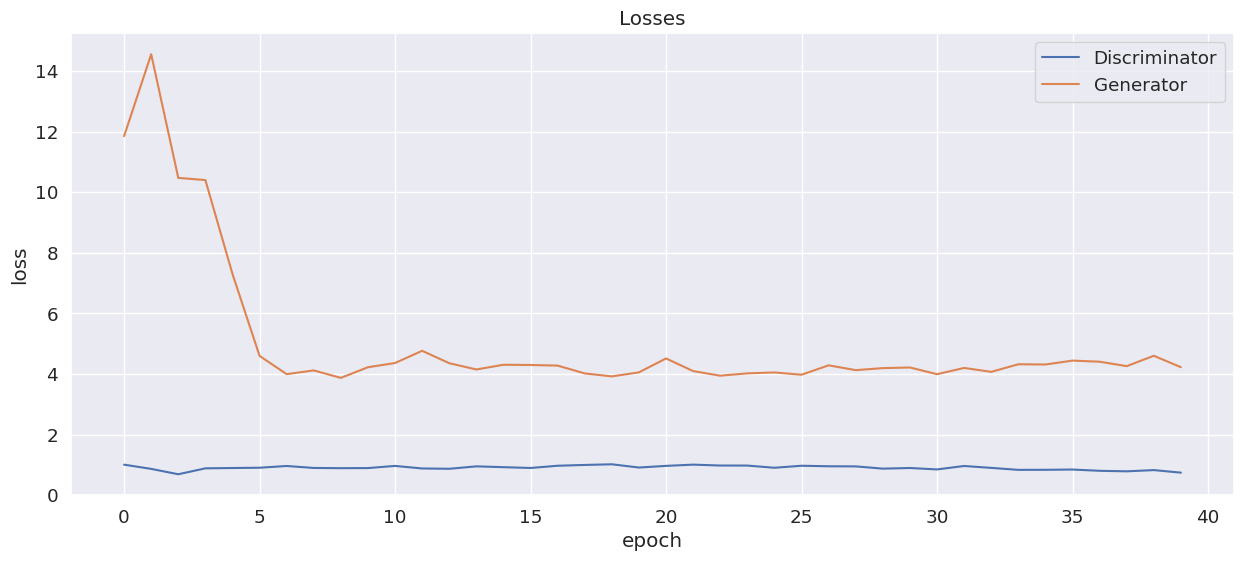

In [83]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [84]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

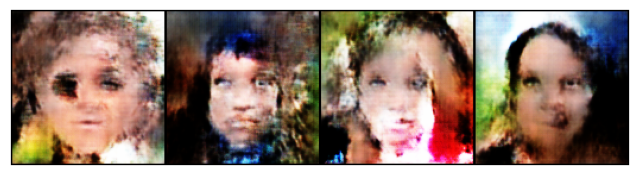

In [85]:
show_images(fake_images.to('cpu'))

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [86]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
    ]))

In [87]:
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np

# ⚙ Параметры
sample_size = 500  # оставить меньше для разумного времени LOO

# 1. Собираем реальные изображения на GPU
real_images = torch.stack([train_ds[i][0] for i in range(sample_size)]).to(device)  # [B, C, H, W]

# 2. Генерируем фейковые изображения на GPU
generator.eval()
with torch.no_grad():
    z = torch.randn(sample_size, latent_size, 1, 1, device=device)
    fake_images = generator(z)

# 3. Объединяем данные и перемещаем в numpy один раз
X_real = real_images.view(sample_size, -1).cpu().numpy()
X_fake = fake_images.view(sample_size, -1).cpu().numpy()
X = np.concatenate([X_real, X_fake], axis=0)
y = np.concatenate([np.ones(sample_size), np.zeros(sample_size)])

# 4. Leave-One-Out + 1-NN (CPU)
loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X):
    knn.fit(X[train_idx], y[train_idx])
    y_true.append(y[test_idx][0])
    y_pred.append(knn.predict(X[test_idx])[0])

acc = accuracy_score(y_true, y_pred)
print(f"Leave-One-Out Accuracy: {acc:.4f}")


Leave-One-Out Accuracy: 0.7660


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

In [ ]:
Accuracy не близка к 1, это значит, что дискриминатор уже не так хорошо отличает сгенерированнные изображения от реальных. В идеале, хотелось бы получить Accuracy близкую к 0.5. Это бы означало, что генератор хорошо научился обманывать дискриминатор.

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

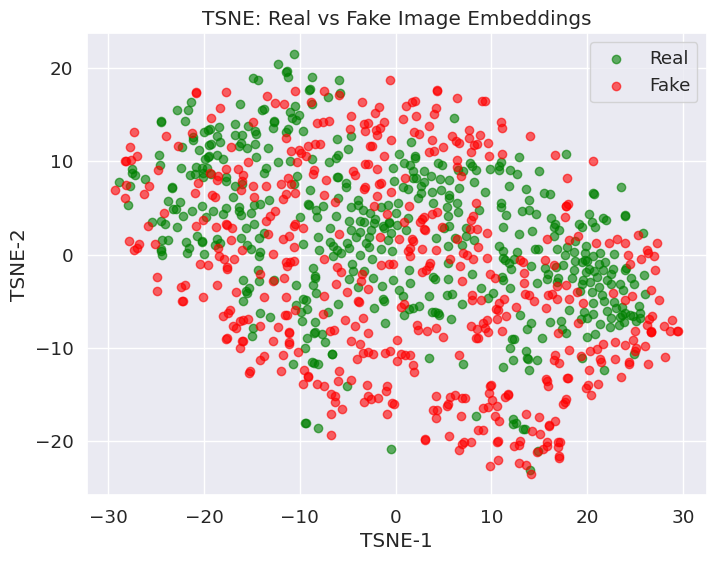

In [88]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# TSNE для визуализации в 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca")
X_embedded = tsne.fit_transform(X)  # X — из предыдущего блока (объединённый real + fake)

# Разделим координаты по классам
X_real_2d = X_embedded[:sample_size]
X_fake_2d = X_embedded[sample_size:]

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(X_real_2d[:, 0], X_real_2d[:, 1], c="green", label="Real", alpha=0.6)
plt.scatter(X_fake_2d[:, 0], X_fake_2d[:, 1], c="red", label="Fake", alpha=0.6)
plt.legend()
plt.title("TSNE: Real vs Fake Image Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()


Прокомментируйте получившийся результат:

Реальные и сгенерированные изображения сильно разделены. Ожидаемый результат при хорошо обученной модели GAN - Реальные и сгенерированные изображения перемешаны в проекции на двумерное пространство.